# finetune ADNI models and analysis
load the predictions for the validation model for each.

and compute the confusion matrix, the precision and f1 score (multiclass)
and roc curve maybe? what curves do we use for multiclass.


In [1]:
# trainer
print("strawberry")
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from trustworthai.utils.fitting_and_inference.get_trainer import get_trainer

# data
from twaidata.torchdatasets.MRI_3D_nolabels_inram_ds import MRI_3D_nolabels_inram_ds

# packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchinfo import summary
from tqdm import tqdm
from collections import defaultdict
from natsort import natsorted
import torchmetrics
print("banana")

strawberry
banana


In [2]:
import os

### Loading ADNI flair mask t1 dataset

In [3]:
ADNI_ds = MRI_3D_nolabels_inram_ds("/home/s2208943/ipdis/data/preprocessed_data/ADNI_300")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [01:56<00:00,  2.49it/s]


In [4]:
IDs = ADNI_ds.getIDs()

In [5]:
len(IDs)

290

### Loading ADNI predictions

In [6]:
def get_output_maps_for_ds(output_maps_dir, ids):
    output_maps_lists = defaultdict(lambda : [])
    key_order = None
    for ID in tqdm(ids, position=0, leave=True):
        output_maps_data = np.load(f"{output_maps_dir}{ID}_out_maps.npz")
        key_order = natsorted(list(output_maps_data.keys()))
        for output_type in key_order:
            output_maps_lists[ID].append(torch.from_numpy(output_maps_data[output_type]))
            
    return output_maps_lists, key_order

In [7]:
model_name = "SSN_Ens_Mean"
output_maps_dir = f"/home/s2208943/ipdis/data/preprocessed_data/ADNI_300_output_maps/{model_name}/"
output_maps, key_order = get_output_maps_for_ds(output_maps_dir, IDs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [01:20<00:00,  3.61it/s]


In [8]:
key_order

['ent', 'pred', 'seg', 'var']

In [9]:
len(output_maps)

290

### Loading ADNI spreadsheets

In [10]:
adni_dir = "/home/s2208943/ipdis/data/ADNI_data/"
spreadsheet_dir = adni_dir
# dataset with clinical variables (e.g age, and a bunch of other factors)
variables_df = pd.read_excel(spreadsheet_dir + "ADNI_300_Variables_for_Analysis.xlsx")

/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [11]:
list(variables_df.iloc[0].items())

[('Unnamed: 0', 'Patient ID'),
 ('GENERAL INFO ', 'DX.bl'),
 ('Unnamed: 2', 'AGE'),
 ('Unnamed: 3', 'PTGENDER'),
 ('Unnamed: 4', 'PTEDUCAT'),
 ('Unnamed: 5', 'PTRACCAT'),
 ('Unnamed: 6', 'APOE4'),
 ('BASELINE BRAIN MEASUREMENTS (% of ICV)', 'Ventricles_bl %'),
 ('Unnamed: 8', 'Hippocampus_bl %'),
 ('Unnamed: 9', 'WholeBrain_bl %'),
 ('Unnamed: 10', 'Entorhinal_bl %'),
 ('Unnamed: 11', 'Fusiform_bl %'),
 ('Unnamed: 12', 'MidTemp_bl %'),
 ('IMAGE ANALYSIS FINDINGS ', 'BMB Y1 Count'),
 ('Unnamed: 14', 'BMB Y2 Count'),
 ('Unnamed: 15', 'BMB Y3 Count'),
 ('MEDICAL HISTORY', 'VSBPDIA'),
 ('Unnamed: 17', 'VSBPSYS'),
 ('Unnamed: 18', 'VSPULSE'),
 ('Unnamed: 19', 'BMI'),
 ('Unnamed: 20', 'CV RISK FACTORS'),
 ('Unnamed: 21', 'E-M RISK FACTORS')]

In [12]:
# dataset with fazekas ratings by Maria. I only have 290 of the 298 due to a few images missing matches, which is a shame
# but hopefully this is enough information. Nice.
ratings_df = pd.read_excel(spreadsheet_dir + "ADNI_300_Sample_MVH_ratings.xlsx")

/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [13]:
def normalize_column(df, column_id):
    # normalizes a column (not inlcuding nan values)
    values = df[column_id].values.astype(np.float32)
    values = values[~np.isnan(values)]
    mean = values.mean()
    std = values.std()
    df[column_id] = (df[column_id].values - mean)/std

In [14]:
def one_hot_encode(df, field, remove_original=True):
    """computes a one hot encoding of the given field"""
    
    onehot_cols = pd.get_dummies(df[field], prefix=field)
    
    if remove_original:
        df = df.drop(columns=[field], inplace=False)
        
    df = pd.concat([df, onehot_cols], axis=1)
    
    return df
    

In [15]:
def convert_symbol_to_nan(df, field, symbol):
    df = df.copy()
    """
    converts all inputs conforming to 'symbol' to np.nan for the given 'field' in the 'df'
    e.g if symbol=' ' and field='totalChl' then any instances of ' ' in the 'totalChl' column will be replaced with np.nan
    """
    values = df[field].values
    locs = values == symbol
    values[locs] = np.nan
    
    df[field] = values
    
    return df

In [16]:
def filter_rows_with_nans(df, field, inplace=False):
    """
    removes all rows from df which have nan for the given field value
    """
    values = df[field].values.astype(np.float32)
    nan_locs = np.where(np.isnan(values))[0]
    df = df.drop(nan_locs, inplace=inplace)
    df = df.reset_index(drop=True)
    
    return df

In [17]:
def prepare_ADNI_dfs(
    ratings_df, variables_df,
    selected_columns=[
        'Patient ID', 'AGE', 'Ventricles_bl %', 'Hippocampus_bl %',
        'WholeBrain_bl %', 'Entorhinal_bl %', 'Fusiform_bl %',
        'MidTemp_bl %', 'BMI', 'DX.bl', 'CV RISK FACTORS', 'APOE4',
        'WMH_PV', 'WMH_Deep', 'Total', 'PTGENDER', 'E-M RISK FACTORS',
    ]):
    
    r_df = ratings_df.copy()
    v_df = variables_df.copy()

    # in the variables df, put all the column headings actually in the heading,
    variables_heading_map = {
        key:column_heading 
        for (column_heading, key) in v_df.iloc[0].items()
    }
    for key, column_heading in variables_heading_map.items():
        v_df[key] = v_df[column_heading].values
        v_df = v_df.drop(columns=[column_heading], inplace=False)
    
    
    # remove any * characters and ' ' from patient IDs
    r_df['Patient ID'] = [str(pid).replace('*', '').replace(' ', '') for pid in r_df['Patient ID'].values]
    v_df['Patient ID'] = [str(pid).replace('*', '').replace(' ', '') for pid in v_df['Patient ID'].values]
    
    # remove any rows that do not have a patient ID. patient ID can be detected due to having a '_S_' string in it.
    pid_locs_rdf = ['_S_' in pid for pid in r_df['Patient ID'].values]
    pid_locs_vdf = ['_S_' in pid for pid in v_df['Patient ID'].values]
    r_df = r_df.loc[pid_locs_rdf]
    v_df = v_df.loc[pid_locs_vdf]
    
    # join the two dataframes
    df = pd.merge(r_df, v_df, how='left')
    
    print(df.keys())
    
    # drop any column that isn't selected
    df = df[selected_columns]
    
    # normalize columns
    for norm_column in ['AGE', 'Ventricles_bl %', 'Hippocampus_bl %', 'WholeBrain_bl %', 'Entorhinal_bl %', 'Fusiform_bl %', 'MidTemp_bl %', 'BMI', 'PTEDUCAT', 'PTRACCAT']:
        if norm_column in selected_columns:
            normalize_column(df, norm_column)
            
    # one hot encoder columns
    for one_hot_col in ['DX.bl', 'CV RISK FACTORS', 'APOE4']:
        if one_hot_col in selected_columns:
            df = one_hot_encode(df, one_hot_col)
            
    # set values of zero to nan for brain measurement fields
    for no_zero_col in ['Ventricles_bl %', 'Hippocampus_bl %', 'WholeBrain_bl %', 'Entorhinal_bl %', 'Fusiform_bl %', 'MidTemp_bl %']:
        df = convert_symbol_to_nan(df, no_zero_col, 0)
            
    # change PTGENDER column to 0,1 (as opposed to 1, 2)
    df['PTGENDER'] = df['PTGENDER'] - 1
    
    # in all selected columns, drop rows that contain a nan value
    for col in df.keys():
        if col not in ['Patient ID']:
            try:
                df = filter_rows_with_nans(df, col)
            except:
                print("failed on: ", col)
    
    return df

In [18]:
combined_df = prepare_ADNI_dfs(ratings_df, variables_df)

Index(['Patient ID', 'Image_year', 'PVS_BG', 'PVS_CS', 'Unnamed: 4',
       'Image_year.1', 'WMH_PV', 'WMH_Deep', 'Total', 'Obs', 'DX.bl', 'AGE',
       'PTGENDER', 'PTEDUCAT', 'PTRACCAT', 'APOE4', 'Ventricles_bl %',
       'Hippocampus_bl %', 'WholeBrain_bl %', 'Entorhinal_bl %',
       'Fusiform_bl %', 'MidTemp_bl %', 'BMB Y1 Count', 'BMB Y2 Count',
       'BMB Y3 Count', 'VSBPDIA', 'VSBPSYS', 'VSPULSE', 'BMI',
       'CV RISK FACTORS', 'E-M RISK FACTORS'],
      dtype='object')


/tmp/ipykernel_1169630/2912575546.py:4: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  onehot_cols = pd.get_dummies(df[field], prefix=field)
/tmp/ipykernel_1169630/2912575546.py:4: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  onehot_cols = pd.get_dummies(df[field], prefix=field)
/tmp/ipykernel_1169630/2912575546.py:4: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  onehot_cols = pd.get_dummies(df[field], prefix=field)


In [19]:
len(combined_df)

283

In [20]:
combined_df.keys()

Index(['Patient ID', 'AGE', 'Ventricles_bl %', 'Hippocampus_bl %',
       'WholeBrain_bl %', 'Entorhinal_bl %', 'Fusiform_bl %', 'MidTemp_bl %',
       'BMI', 'WMH_PV', 'WMH_Deep', 'Total', 'PTGENDER', 'E-M RISK FACTORS',
       'DX.bl_0', 'DX.bl_1', 'DX.bl_2', 'DX.bl_3', 'CV RISK FACTORS_0',
       'CV RISK FACTORS_1', 'CV RISK FACTORS_2', 'APOE4_0', 'APOE4_1',
       'APOE4_2'],
      dtype='object')

### Setting up combined dataset and dataloader

1) [x] add the extra channels (output predictions) to the ADNI dataloader
2) [x] split the data into train test and validate
3) [x] add the augmentation for the train (and optionally for val and test)
4) [x] combine each dataset with its set of clinical data
5) [x] add ability to select specific columns as input and labels

In [21]:
from torch.utils.data import Dataset, ConcatDataset, DataLoader
from trustworthai.utils.data_preprep.splits import cross_validate_split

In [22]:
### defining the augmentation procedure
from trustworthai.utils.augmentation.standard_transforms import (
    RandomFlip, GaussianBlur, GaussianNoise,
    RandomResizeCrop, RandomAffine,
    NormalizeImg, PairedCompose, LabelSelect,
    PairedCentreCrop, CropZDim,
)
import torch


def get_transforms():
    transforms = [
        LabelSelect(label_id=1),
        RandomFlip(p=0.5, orientation="horizontal"),
        # GaussianBlur(p=0.5, kernel_size=7, sigma=(.1, 1.5)),
        # GaussianNoise(p=0.2, mean=0, sigma=0.2),
        RandomAffine(p=0.2, shear=(-18,18)),
        RandomAffine(p=0.2, degrees=15),
        RandomAffine(p=0.2, translate=(-0.1,0.1)),
        RandomAffine(p=0.2, scale=(0.9, 1.1)),
#         #RandomResizeCrop(p=1., scale=(0.6, 1.), ratio=(3./4., 4./3.))

#         #RandomResizeCrop(p=1., scale=(0.3, 0.5), ratio=(3./4., 4./3.)) # ssn
    ]
    transforms.append(lambda x, y: (x, y.squeeze().type(torch.long)))
    return PairedCompose(transforms)

In [23]:
### combine the clinical scores data into the x information.
# generated with chatgpt
class ClinicalDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, fields, target_field):
        self.base_dataset = base_dataset
        self.fields = fields
        self.target_field = target_field

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, index):
        x, y, clin_data = self.base_dataset[index]
        clin_data_fields = clin_data[self.fields].values
        clin_data_tensor = torch.from_numpy(clin_data_fields.astype(np.float32))
        target_field = clin_data[self.target_field]
        return (x, clin_data_tensor), target_field

In [24]:
# torch dataset that filters out nans
class NonNanDataset(Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset
        self.indices = []

        for i in range(len(self.original_dataset)):
            (x, clin_data), y = self.original_dataset[i]
            if not (np.isnan(y) or torch.any(torch.isnan(clin_data))):
                self.indices.append(i)

    def __getitem__(self, index):
        original_index = self.indices[index]
        return self.original_dataset[original_index]

    def __len__(self):
        return len(self.indices)


In [25]:
class RepeatDataset(Dataset):
    def __init__(self, original_dataset, repeats):
        self.original_dataset = original_dataset
        self.repeats=repeats
        
    def __getitem__(self, idx):
        return self.original_dataset[idx % len(self.original_dataset)]
    
    def __len__(self):
        return len(self.original_dataset) * self.repeats

In [26]:
class AddChannelsDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, extra_x_channels_lists, IDs):
        self.base_dataset = base_dataset
        self.extra_x_channels_lists = extra_x_channels_lists
        self.IDs = IDs
        
    def __getitem__(self, idx):
        data = self.base_dataset[idx]
        ID = self.IDs[idx]
        x = data[0]
        # print(x.shape)
        # print(torch.stack(self.extra_x_channels_lists[ID]).shape)
        x = torch.cat([x, torch.stack(self.extra_x_channels_lists[ID])], dim=0)
        
        return (x, *data[1:], ID)
        
    def __len__(self):
        return len(self.base_dataset)

In [27]:
class ExtractYChannelDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, y_channel_idx):
        self.base_dataset = base_dataset
        self.y_channel_idx = y_channel_idx
        
        self.x_channels = [i for i in range(base_dataset[0].shape[0])]
        self.x_channels.remove(y_channel_idx)
        
    def __getitem__(self, idx):
        data = self.base_dataset[idx]
        return data[self.x_channels], data[self.y_channel_idx].unsqueeze(0)
    
    def __len__(self):
        return len(self.base_dataset)

In [28]:
class AugmentedDataset(Dataset):
    def __init__(self, base_dataset, transforms):
        self.base_dataset = base_dataset
        self.transforms = transforms
        
    def __getitem__(self, idx):
        (x, y, clin_data), label = self.base_dataset[idx]
        return (*self.transforms(x, y), clin_data), label
    
    def __len__(self):
        return len(self.base_dataset)

In [29]:
class ImgsAndDfDataset(Dataset):
    def __init__(self, base_dataset, df, selected_fields, label_field):
        self.base_dataset = base_dataset
        self.df = df
        self.selected_fields = selected_fields
        self.label_field = label_field
        
    def __getitem__(self, idx):
        x, y, ID = self.base_dataset[idx]
        clin_data = self.df.loc[self.df['Patient ID'] == "_".join(ID.split('_')[1:-1])]
        fields = clin_data[self.selected_fields].values
        
        # print(len(fields))
        label = clin_data[self.label_field].values[0]
        
        return (x, y, fields), label
    
    def __len__(self):
        return len(self.base_dataset)

In [30]:
class SkipBadIndexesDs(Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
        valid_indexes = []
        
        for idx in tqdm(range(len(base_dataset)), position=0, leave=True):
            try:
                _ = base_dataset[idx]
                valid_indexes.append(idx)
            except IndexError:
                continue
                
        self.valid_indexes = valid_indexes
    
    def __getitem__(self, idx):
        return self.base_dataset[self.valid_indexes[idx]]
    
    def __len__(self):
        return len(self.valid_indexes)

In [31]:
class ConsumedDataset(Dataset):
    def __init__(self, base_dataset):
        self.elements = [data for data in tqdm(base_dataset, position=0, leave=True)]
        
    def __getitem__(self, idx):
        return self.elements[idx]
    
    def __len__(self):
        return len(self.elements)

In [32]:
fields = ['AGE', 'Ventricles_bl %', 'Hippocampus_bl %',
       'WholeBrain_bl %', 'Entorhinal_bl %', 'Fusiform_bl %', 'MidTemp_bl %',
       'BMI', 'PTGENDER', 'E-M RISK FACTORS',
       'DX.bl_0', 'DX.bl_1', 'DX.bl_2', 'DX.bl_3', 'CV RISK FACTORS_0',
       'CV RISK FACTORS_1', 'CV RISK FACTORS_2', 'APOE4_0', 'APOE4_1',
       'APOE4_2']

label = 'WMH_PV'

imgs_ds = ADNI_ds
imgs_ds = ExtractYChannelDataset(imgs_ds, 1)
imgs_ds = AddChannelsDataset(imgs_ds, output_maps, IDs)
imgs_ds = ImgsAndDfDataset(imgs_ds, combined_df, selected_fields=fields, label_field=label)
imgs_ds = SkipBadIndexesDs(imgs_ds)
imgs_ds = ConsumedDataset(imgs_ds)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:11<00:00, 24.95it/s]


In [33]:
train_ds, val_ds, test_ds = cross_validate_split(imgs_ds, val_prop=0.15, test_prop=0.15, seed=3407, split=0, test_fold_smooth=1)

In [34]:
train_ds = AugmentedDataset(train_ds, get_transforms())
val_ds = AugmentedDataset(val_ds, get_transforms())
test_ds = test_ds# AugmentedDataset(test_ds, get_transforms())

In [35]:
# so quite a few images are missing a matching ID row it seems....
len(train_ds), len(val_ds), len(test_ds)

(193, 41, 42)

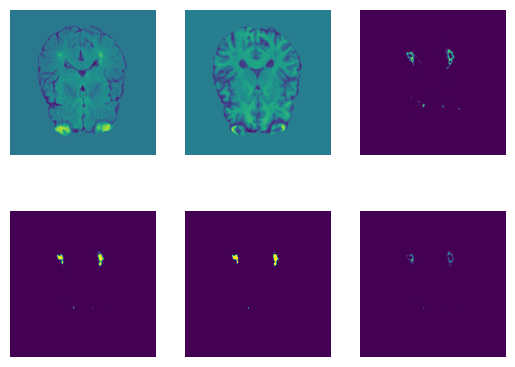

In [36]:
data = train_ds[50]
x = data[0][0]
mask = data[0][1]
#x, mask = transforms(x, mask)
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(x[i][30])
    plt.axis('off')

### formatting the data into input types to use and creating the dataloader

current data shape is ((x, mask, clin_values), label)

In [37]:
import torchvision as tv

class FormatDataset(Dataset):
    def __init__(self, base_dataset, slice_range=(25,45), centre_crop=(220,160), channels=['flair']):
        self.base_dataset = base_dataset
        self.slice_range = slice_range
        self.centre_crop = centre_crop
        self.channels = channels
        
    def __getitem__(self, idx):
        channels_id = {
            "flair":0,
            "t1":1,
            "ent":2,
            "pred":3,
            "seg":4,
            "var":5,
        }
        
        (x_3d, mask, clin_data), label = self.base_dataset[idx]
        
        # print(x_3d.shape)
        
        selected_channels = [channels_id[c] for c in self.channels]
        
        # Select the slices from the 3D image
        x_3d = x_3d[selected_channels]
        # print(x_3d.shape)
        
        slices = np.arange(self.slice_range[0], self.slice_range[1], 1)
        x_3d = x_3d[:, slices]
        # print(x_3d.shape)
        
        # Reshape the slices into C*v 2D tensors
        x_2d = torch.reshape(x_3d, (-1, x_3d.shape[-2], x_3d.shape[-1]))
        # x_2d = x_3d
        
        # print(x_2d.shape)
        
        x_2d = tv.transforms.functional.center_crop(x_2d, self.centre_crop)
        
        # print(x_2d.shape)
        
        return (x_2d, clin_data.astype(np.float32).squeeze()), label
        
    
    def __len__(self):
        return len(self.base_dataset)

In [38]:
channels = ['ent']
train_ds_2d = FormatDataset(train_ds, channels=channels)
val_ds_2d = FormatDataset(val_ds, channels=channels)
test_ds_2d = FormatDataset(test_ds, channels=channels)

In [39]:
batch_size = 12
train_dataloader = DataLoader(train_ds_2d, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_ds_2d, batch_size=batch_size, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_ds_2d, batch_size=batch_size, shuffle=False, num_workers=4)

In [40]:
val_ds_2d[0][0][1].astype(np.float32).squeeze()

array([-0.02500828,  0.66227365, -0.582079  ,  0.21757682, -1.0463433 ,
       -1.0485672 , -1.0964288 ,  0.39493522,  1.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ],
      dtype=float32)

In [41]:
out = next(iter(test_dataloader))

### Setting up model for training

In [42]:
from functools import partial
from typing import Any, Callable, List, Optional, Type, Union

import torch
import torch.nn as nn
from torch import Tensor


def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition" https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        channel_size_divide=1,
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64//channel_size_divide
        self.init_inplanes = self.inplanes
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64//channel_size_divide, layers[0])
        self.layer2 = self._make_layer(block, 128//channel_size_divide, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256//channel_size_divide, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512//channel_size_divide, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        #x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


def _resnet(
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    weights,#: Optional[WeightsEnum],
    progress: bool,
    channel_size_divide,
    **kwargs: Any,
) -> ResNet:
    if weights is not None:
        _ovewrite_named_param(kwargs, "num_classes", len(weights.meta["categories"]))

    model = ResNet(block, layers, channel_size_divide, **kwargs)

    if weights is not None:
        model.load_state_dict(weights.get_state_dict(progress=progress))

    return model

def resnet18(*, progress: bool = True, channel_size_divide=2, **kwargs: Any) -> ResNet:
    return _resnet(BasicBlock, [2, 2, 2, 2], None, progress, channel_size_divide=channel_size_divide, **kwargs)

def resnet34(*, progress: bool = True, **kwargs: Any) -> ResNet:

    return _resnet(BasicBlock, [3, 4, 6, 3], None, progress, **kwargs)

In [43]:
### selecting a model

class PredictionModel(torch.nn.Module):
    # uses a modified resnet that bypasses the usual 
    def __init__(self, image_channels, num_clin_features, out_classes, latent_fc_features=64, channel_size_divide=2, finetune_head=False):
        super().__init__()
        model_base = resnet18(channel_size_divide=channel_size_divide)
        self.channel_size_divide = channel_size_divide
        model_base.conv1 = nn.Conv2d(image_channels, model_base.init_inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        
        self.model_base = model_base
        self.finetune_head = finetune_head
        
        # replace the head of the model with another layer.
        self.fc1 = nn.Linear(model_base.fc.in_features//channel_size_divide + num_clin_features, latent_fc_features)
        self.a = nn.ReLU()
        self.fc2 = nn.Linear(latent_fc_features, out_classes)
        
    def forward(self, inp):
        
        
        x = inp[0]
        clin_data = inp[1]
        
        # x = None
        
        if x != None:
            if not self.finetune_head:
                features = self.model_base(x)
            else:
                with torch.no_grad():
                    features = self.model_base(x)
        else:
            features = torch.zeros(inp[0].shape[0], 512//self.channel_size_divide).cuda()
        dense_input = torch.cat([features, clin_data], dim=1)
        
        out = self.fc2(self.a(self.fc1(dense_input)))
        
        return out
        
        

In [44]:
class PredictionModelNHeadLayer(torch.nn.Module):
    # uses a modified resnet that bypasses the usual 
    def __init__(self, image_channels, num_clin_features, out_classes, latent_fc_features=64, channel_size_divide=2, finetune_head=False, n_heads=3):
        super().__init__()
        model_base = resnet18(channel_size_divide=channel_size_divide)
        self.channel_size_divide = channel_size_divide
        model_base.conv1 = nn.Conv2d(image_channels, model_base.init_inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        
        self.model_base = model_base
        self.finetune_head = finetune_head
        
        self.a = nn.ReLU()
        if n_heads > 1:
            # replace the head of the model with another layer.
            self.fc1 = nn.Linear(model_base.fc.in_features//channel_size_divide + num_clin_features, latent_fc_features)
            self.extra_heads = nn.ModuleList([nn.Linear(latent_fc_features, latent_fc_features) for i in range(n_heads - 2)] + [nn.Linear(latent_fc_features, out_classes)])
            
        else:
            # replace the head of the model with another layer.
            self.fc1 = nn.Linear(model_base.fc.in_features//channel_size_divide + num_clin_features, out_classes)
            self.extra_heads = None
        
        if self.extra_heads:
            print(self.extra_heads)
        
    def forward(self, inp):
        
        
        x = inp[0]
        clin_data = inp[1]
        
        # x = None
        
        if x != None:
            if not self.finetune_head:
                features = self.model_base(x)
            else:
                with torch.no_grad():
                    features = self.model_base(x)
        else:
            features = torch.zeros(inp[0].shape[0], 512//self.channel_size_divide).cuda()
        dense_input = torch.cat([features, clin_data], dim=1)
        
        out = self.fc1(dense_input)
        
        if self.extra_heads:
            for h in self.extra_heads:
                out = h(self.a(out))
        
        return out

In [45]:
labels = []
for data in train_ds:
    labels.append(data[-1].item())
labels = torch.Tensor(labels)
class_counts = [(labels==i).sum().item() for i in range(4)]
print(class_counts)

[29, 115, 38, 11]


In [46]:
class xent_wrapper(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_loss = torch.nn.CrossEntropyLoss(weight = 1.0 / torch.tensor(class_counts, dtype=torch.float))
        # self.base_loss = torch.nn.CrossEntropyLoss()
    def forward(self, y_hat, y):
        return self.base_loss(y_hat, y.type(torch.long))

In [47]:
import torchmetrics
f1_metric = torchmetrics.F1Score(task='multiclass', num_classes=4) # note need to set the F1 score correctly depending on the number of classes in the task!!

In [48]:
for channels in [['ent'], ['pred'], ['ent', 'pred'], ['seg'], ['flair']]:
    channel_id = "_".join(channels)
    print(channel_id)

ent
pred
ent_pred
seg
flair


In [50]:
len(train_ds_2d), len(val_ds_2d), len(test_ds_2d)

(193, 41, 42)

In [49]:
from collections import defaultdict
all_preds = defaultdict(lambda : {})
all_labels = defaultdict(lambda: {})

for channels in [['ent'], ['pred'], ['ent', 'pred']]:#, ['seg'], ['flair']]:
    for si, seed in enumerate([912, 128, 418]): # used an online random number generator to get these
        combined_preds_val = []
        combined_labels_val = []
        combined_preds_test = []
        combined_labels_test = []
        for split in range(6):
            train_ds, val_ds, test_ds = cross_validate_split(imgs_ds, val_prop=0.15, test_prop=0.15, seed=3407, split=split, test_fold_smooth=1)
            # train_ds = AugmentedDataset(train_ds, get_transforms())
            # val_ds = AugmentedDataset(val_ds, get_transforms())
            test_ds = test_ds# AugmentedDataset(test_ds, get_transforms())

            # channels = ['pred']
            train_ds_2d = ConsumedDataset(FormatDataset(train_ds, channels=channels))
            val_ds_2d = ConsumedDataset(FormatDataset(val_ds, channels=channels))
            test_ds_2d = FormatDataset(test_ds, channels=channels)

            batch_size = 12
            train_dataloader = DataLoader(train_ds_2d, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True)
            val_dataloader = DataLoader(val_ds_2d, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)
            test_dataloader = DataLoader(test_ds_2d, batch_size=batch_size, shuffle=False, num_workers=4)

            image_channels = train_ds_2d[0][0][0].shape[0]
            print(image_channels)
            clin_features = len(fields)
            torch.manual_seed(seed)
            # model_raw = PredictionModel(image_channels=image_channels, num_clin_features=clin_features, out_classes=4, channel_size_divide=8, finetune_head=True)#.cuda()
            model_raw = PredictionModelNHeadLayer(image_channels=image_channels, num_clin_features=clin_features, out_classes=4, channel_size_divide=8, finetune_head=True, n_heads=3)
            loss = xent_wrapper()


            ### training the model
            # setup optimizer and model wrapper

            weight_decay = 0.01#0.05
            max_epochs = 100
            lr=2e-4
            early_stop_patience = 7

            optimizer_params={"lr":lr, "weight_decay":weight_decay}
            optimizer = torch.optim.Adam
            lr_scheduler_params={"milestones":[1000], "gamma":0.5}
            lr_scheduler_constructor = torch.optim.lr_scheduler.MultiStepLR

            # wrap the model in the pytorch_lightning module that automates training
            # todo: this script needs filling in. I need to be able to replicate this for each model type which is why I have done this
            # I then need to do it for PVWMH as well...
            model = StandardLitModelWrapper(model=model_raw, loss=loss, 
                                            logging_metric=lambda : None,
                                            optimizer_params=optimizer_params,
                                            lr_scheduler_params=lr_scheduler_params,
                                            optimizer_constructor=optimizer,
                                            lr_scheduler_constructor=lr_scheduler_constructor,
                                           )

            # train the model
            trainer = get_trainer(max_epochs, ".", early_stop_patience=early_stop_patience)

            trainer.fit(model, train_dataloader, val_dataloader)

            r = trainer.validate(model, val_dataloader, ckpt_path='best')
            print(f"val_loss: {r[0]['val_loss']}")

            preds_val = []
            ys_val = []

            for data in val_dataloader:
                with torch.no_grad():
                    (x, clin_data), y = data
                    out = model.cuda()((x.cuda(), clin_data.cuda())).cpu()
                    pred = torch.nn.functional.softmax(out, dim=1)
                    preds_val.extend(pred.argmax(dim=1).cpu().numpy())
                    ys_val.extend(y.cpu().numpy())


            preds_test = []
            ys_test = []

            for data in test_dataloader:
                with torch.no_grad():
                    (x, clin_data), y = data
                    out = model.cuda()((x.cuda(), clin_data.cuda())).cpu()
                    pred = torch.nn.functional.softmax(out, dim=1)
                    preds_test.extend(pred.argmax(dim=1).cpu().numpy())
                    ys_test.extend(y.cpu().numpy())
            
            combined_preds_val.extend(preds_val)
            combined_preds_test.extend(preds_test)
            combined_labels_val.extend(ys_val)
            combined_labels_test.extend(ys_test)
        
        all_preds["_".join(channels)][si] = {"val": combined_preds_val, "test":combined_preds_test}
        all_labels["_".join(channels)][si] = {"val": combined_labels_val, "test":combined_labels_test}
                                  

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 422.46it/s]


20
ModuleList(
  (0): Linear(in_features=64, out_features=64, bias=True)
  (1): Linear(in_features=64, out_features=4, bias=True)
)


/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/lightning_lite/plugins/environments/slurm.py:167: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/s2208943/miniconda3/envs/uq/lib/python3.10/sit ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:604: UserWarning: Checkpoint directory /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                      | Params
-------------------

Sanity Checking: 0it [00:00, ?it/s]

/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1595: PossibleUserWarning: The number of training batches (17) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.422


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.01. New best score: 1.409


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.01. New best score: 1.397


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.024 >= min_delta = 0.01. New best score: 1.373


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.038 >= min_delta = 0.01. New best score: 1.335


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.028 >= min_delta = 0.01. New best score: 1.307


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.023 >= min_delta = 0.01. New best score: 1.284


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.027 >= min_delta = 0.01. New best score: 1.257


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.025 >= min_delta = 0.01. New best score: 1.232


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.020 >= min_delta = 0.01. New best score: 1.212


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.031 >= min_delta = 0.01. New best score: 1.181


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.031 >= min_delta = 0.01. New best score: 1.149


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.033 >= min_delta = 0.01. New best score: 1.116


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.034 >= min_delta = 0.01. New best score: 1.082


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.032 >= min_delta = 0.01. New best score: 1.050


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.029 >= min_delta = 0.01. New best score: 1.021


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.019 >= min_delta = 0.01. New best score: 1.002


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.025 >= min_delta = 0.01. New best score: 0.977


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.037 >= min_delta = 0.01. New best score: 0.940


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.022 >= min_delta = 0.01. New best score: 0.918


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.019 >= min_delta = 0.01. New best score: 0.899


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0.01. New best score: 0.878


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.022 >= min_delta = 0.01. New best score: 0.856


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.023 >= min_delta = 0.01. New best score: 0.833


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.027 >= min_delta = 0.01. New best score: 0.806


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0.01. New best score: 0.785


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.018 >= min_delta = 0.01. New best score: 0.768


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.01. New best score: 0.757


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.020 >= min_delta = 0.01. New best score: 0.738


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.01. New best score: 0.725


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 7 records. Best score: 0.725. Signaling Trainer to stop.
Restoring states from the checkpoint path at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/epoch=51-step=884.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/epoch=51-step=884.ckpt


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.7175280451774597
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
val_loss: 0.7175280451774597


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 455.25it/s]


20
ModuleList(
  (0): Linear(in_features=64, out_features=64, bias=True)
  (1): Linear(in_features=64, out_features=4, bias=True)
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                      | Params
----------------------------------------------------
0 | model | PredictionModelNHeadLayer | 706 K 
1 | loss  | xent_wrapper              | 0     
----------------------------------------------------
706 K     Trainable params
0         Non-trainable params
706 K     Total params
2.825     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.392


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.01. New best score: 1.379


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.022 >= min_delta = 0.01. New best score: 1.357


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.038 >= min_delta = 0.01. New best score: 1.319


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.026 >= min_delta = 0.01. New best score: 1.293


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.027 >= min_delta = 0.01. New best score: 1.265


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0.01. New best score: 1.244


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0.01. New best score: 1.224


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.023 >= min_delta = 0.01. New best score: 1.201


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.050 >= min_delta = 0.01. New best score: 1.150


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.01. New best score: 1.138


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.044 >= min_delta = 0.01. New best score: 1.094


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.029 >= min_delta = 0.01. New best score: 1.064


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.019 >= min_delta = 0.01. New best score: 1.045


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.030 >= min_delta = 0.01. New best score: 1.016


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.022 >= min_delta = 0.01. New best score: 0.994


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.028 >= min_delta = 0.01. New best score: 0.966


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.046 >= min_delta = 0.01. New best score: 0.919


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.049 >= min_delta = 0.01. New best score: 0.870


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.031 >= min_delta = 0.01. New best score: 0.839


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.031 >= min_delta = 0.01. New best score: 0.808


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.017 >= min_delta = 0.01. New best score: 0.791


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.01. New best score: 0.780


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.020 >= min_delta = 0.01. New best score: 0.760


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.028 >= min_delta = 0.01. New best score: 0.732


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 7 records. Best score: 0.732. Signaling Trainer to stop.
Restoring states from the checkpoint path at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/epoch=41-step=714.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/epoch=41-step=714.ckpt


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.7315378189086914
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
val_loss: 0.7315378189086914


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 465.19it/s]


20
ModuleList(
  (0): Linear(in_features=64, out_features=64, bias=True)
  (1): Linear(in_features=64, out_features=4, bias=True)
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                      | Params
----------------------------------------------------
0 | model | PredictionModelNHeadLayer | 706 K 
1 | loss  | xent_wrapper              | 0     
----------------------------------------------------
706 K     Trainable params
0         Non-trainable params
706 K     Total params
2.825     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.390


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.016 >= min_delta = 0.01. New best score: 1.374


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0.01. New best score: 1.353


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.032 >= min_delta = 0.01. New best score: 1.321


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.025 >= min_delta = 0.01. New best score: 1.296


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.020 >= min_delta = 0.01. New best score: 1.276


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.020 >= min_delta = 0.01. New best score: 1.256


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.022 >= min_delta = 0.01. New best score: 1.234


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.023 >= min_delta = 0.01. New best score: 1.212


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.050 >= min_delta = 0.01. New best score: 1.161


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.014 >= min_delta = 0.01. New best score: 1.147


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.034 >= min_delta = 0.01. New best score: 1.113


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.036 >= min_delta = 0.01. New best score: 1.076


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0.01. New best score: 1.061


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.027 >= min_delta = 0.01. New best score: 1.034


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.031 >= min_delta = 0.01. New best score: 1.003


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.030 >= min_delta = 0.01. New best score: 0.973


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.045 >= min_delta = 0.01. New best score: 0.928


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.059 >= min_delta = 0.01. New best score: 0.869


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.046 >= min_delta = 0.01. New best score: 0.823


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.018 >= min_delta = 0.01. New best score: 0.805


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.01. New best score: 0.794


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.024 >= min_delta = 0.01. New best score: 0.771


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.043 >= min_delta = 0.01. New best score: 0.728


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.01. New best score: 0.715


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 7 records. Best score: 0.715. Signaling Trainer to stop.
Restoring states from the checkpoint path at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/epoch=41-step=714-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/epoch=41-step=714-v1.ckpt


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.7151492238044739
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
val_loss: 0.7151492238044739


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 246.68it/s]


20
ModuleList(
  (0): Linear(in_features=64, out_features=64, bias=True)
  (1): Linear(in_features=64, out_features=4, bias=True)
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                      | Params
----------------------------------------------------
0 | model | PredictionModelNHeadLayer | 706 K 
1 | loss  | xent_wrapper              | 0     
----------------------------------------------------
706 K     Trainable params
0         Non-trainable params
706 K     Total params
2.825     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.391


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.014 >= min_delta = 0.01. New best score: 1.377


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.014 >= min_delta = 0.01. New best score: 1.363


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.038 >= min_delta = 0.01. New best score: 1.324


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.029 >= min_delta = 0.01. New best score: 1.296


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.022 >= min_delta = 0.01. New best score: 1.274


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.023 >= min_delta = 0.01. New best score: 1.251


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.022 >= min_delta = 0.01. New best score: 1.229


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.030 >= min_delta = 0.01. New best score: 1.199


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.049 >= min_delta = 0.01. New best score: 1.151


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.01. New best score: 1.140


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.042 >= min_delta = 0.01. New best score: 1.099


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.043 >= min_delta = 0.01. New best score: 1.056


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.030 >= min_delta = 0.01. New best score: 1.026


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.029 >= min_delta = 0.01. New best score: 0.997


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.032 >= min_delta = 0.01. New best score: 0.965


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.053 >= min_delta = 0.01. New best score: 0.912


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.057 >= min_delta = 0.01. New best score: 0.855


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.032 >= min_delta = 0.01. New best score: 0.822


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.025 >= min_delta = 0.01. New best score: 0.797


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.01. New best score: 0.784


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.037 >= min_delta = 0.01. New best score: 0.748


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.022 >= min_delta = 0.01. New best score: 0.726


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 7 records. Best score: 0.726. Signaling Trainer to stop.
Restoring states from the checkpoint path at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/epoch=41-step=714-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/epoch=41-step=714-v2.ckpt


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.7255975008010864
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
val_loss: 0.7255975008010864


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 326.74it/s]


20
ModuleList(
  (0): Linear(in_features=64, out_features=64, bias=True)
  (1): Linear(in_features=64, out_features=4, bias=True)
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                      | Params
----------------------------------------------------
0 | model | PredictionModelNHeadLayer | 706 K 
1 | loss  | xent_wrapper              | 0     
----------------------------------------------------
706 K     Trainable params
0         Non-trainable params
706 K     Total params
2.825     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.389


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.01. New best score: 1.377


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.017 >= min_delta = 0.01. New best score: 1.361


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.039 >= min_delta = 0.01. New best score: 1.322


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.027 >= min_delta = 0.01. New best score: 1.295


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.023 >= min_delta = 0.01. New best score: 1.272


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.028 >= min_delta = 0.01. New best score: 1.243


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.019 >= min_delta = 0.01. New best score: 1.225


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.047 >= min_delta = 0.01. New best score: 1.178


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.026 >= min_delta = 0.01. New best score: 1.151


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.020 >= min_delta = 0.01. New best score: 1.132


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.01. New best score: 1.121


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.073 >= min_delta = 0.01. New best score: 1.048


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.019 >= min_delta = 0.01. New best score: 1.030


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.071 >= min_delta = 0.01. New best score: 0.959


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0.01. New best score: 0.938


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0.01. New best score: 0.922


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.051 >= min_delta = 0.01. New best score: 0.871


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.037 >= min_delta = 0.01. New best score: 0.834


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.034 >= min_delta = 0.01. New best score: 0.800


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.019 >= min_delta = 0.01. New best score: 0.781


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.019 >= min_delta = 0.01. New best score: 0.762


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.034 >= min_delta = 0.01. New best score: 0.728


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 7 records. Best score: 0.728. Signaling Trainer to stop.
Restoring states from the checkpoint path at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/epoch=47-step=816.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/epoch=47-step=816.ckpt


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.7240493297576904
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
val_loss: 0.7240493297576904


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 216.73it/s]


20
ModuleList(
  (0): Linear(in_features=64, out_features=64, bias=True)
  (1): Linear(in_features=64, out_features=4, bias=True)
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                      | Params
----------------------------------------------------
0 | model | PredictionModelNHeadLayer | 706 K 
1 | loss  | xent_wrapper              | 0     
----------------------------------------------------
706 K     Trainable params
0         Non-trainable params
706 K     Total params
2.825     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1595: PossibleUserWarning: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.389


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.019 >= min_delta = 0.01. New best score: 1.369


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.025 >= min_delta = 0.01. New best score: 1.344


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.036 >= min_delta = 0.01. New best score: 1.309


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.022 >= min_delta = 0.01. New best score: 1.287


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0.01. New best score: 1.266


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.028 >= min_delta = 0.01. New best score: 1.238


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.023 >= min_delta = 0.01. New best score: 1.215


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0.01. New best score: 1.195


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.019 >= min_delta = 0.01. New best score: 1.175


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.048 >= min_delta = 0.01. New best score: 1.127


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.030 >= min_delta = 0.01. New best score: 1.097


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.019 >= min_delta = 0.01. New best score: 1.077


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.024 >= min_delta = 0.01. New best score: 1.053


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.014 >= min_delta = 0.01. New best score: 1.039


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.049 >= min_delta = 0.01. New best score: 0.990


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.019 >= min_delta = 0.01. New best score: 0.971


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.016 >= min_delta = 0.01. New best score: 0.955


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.027 >= min_delta = 0.01. New best score: 0.927


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.023 >= min_delta = 0.01. New best score: 0.905


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.01. New best score: 0.892


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.020 >= min_delta = 0.01. New best score: 0.871


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.016 >= min_delta = 0.01. New best score: 0.855


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.01. New best score: 0.842


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.022 >= min_delta = 0.01. New best score: 0.820


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.01. New best score: 0.809


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.024 >= min_delta = 0.01. New best score: 0.785


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.029 >= min_delta = 0.01. New best score: 0.755


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.01. New best score: 0.742


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 7 records. Best score: 0.742. Signaling Trainer to stop.
Restoring states from the checkpoint path at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/epoch=52-step=795.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/epoch=52-step=795.ckpt


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.7423040866851807
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
val_loss: 0.7423040866851807


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 238.87it/s]


20
ModuleList(
  (0): Linear(in_features=64, out_features=64, bias=True)
  (1): Linear(in_features=64, out_features=4, bias=True)
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                      | Params
----------------------------------------------------
0 | model | PredictionModelNHeadLayer | 706 K 
1 | loss  | xent_wrapper              | 0     
----------------------------------------------------
706 K     Trainable params
0         Non-trainable params
706 K     Total params
2.825     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.389


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.01. New best score: 1.379


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0.01. New best score: 1.358


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.052 >= min_delta = 0.01. New best score: 1.306


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.034 >= min_delta = 0.01. New best score: 1.272


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.033 >= min_delta = 0.01. New best score: 1.239


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.031 >= min_delta = 0.01. New best score: 1.208


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.030 >= min_delta = 0.01. New best score: 1.178


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.037 >= min_delta = 0.01. New best score: 1.141


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.038 >= min_delta = 0.01. New best score: 1.103


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.033 >= min_delta = 0.01. New best score: 1.070


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.032 >= min_delta = 0.01. New best score: 1.039


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.027 >= min_delta = 0.01. New best score: 1.012


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.01. New best score: 1.001


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.039 >= min_delta = 0.01. New best score: 0.962


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.022 >= min_delta = 0.01. New best score: 0.939


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.024 >= min_delta = 0.01. New best score: 0.915


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.034 >= min_delta = 0.01. New best score: 0.881


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.020 >= min_delta = 0.01. New best score: 0.861


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.038 >= min_delta = 0.01. New best score: 0.823


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.014 >= min_delta = 0.01. New best score: 0.809


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.016 >= min_delta = 0.01. New best score: 0.793


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.031 >= min_delta = 0.01. New best score: 0.761


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.016 >= min_delta = 0.01. New best score: 0.746


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.016 >= min_delta = 0.01. New best score: 0.730


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.01. New best score: 0.720


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.019 >= min_delta = 0.01. New best score: 0.700


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.027 >= min_delta = 0.01. New best score: 0.673


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 7 records. Best score: 0.673. Signaling Trainer to stop.
Restoring states from the checkpoint path at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/epoch=54-step=935.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/epoch=54-step=935.ckpt


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.6731027960777283
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
val_loss: 0.6731027960777283


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 236.12it/s]


20
ModuleList(
  (0): Linear(in_features=64, out_features=64, bias=True)
  (1): Linear(in_features=64, out_features=4, bias=True)
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                      | Params
----------------------------------------------------
0 | model | PredictionModelNHeadLayer | 706 K 
1 | loss  | xent_wrapper              | 0     
----------------------------------------------------
706 K     Trainable params
0         Non-trainable params
706 K     Total params
2.825     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.382


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.01. New best score: 1.369


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.051 >= min_delta = 0.01. New best score: 1.319


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.039 >= min_delta = 0.01. New best score: 1.280


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.019 >= min_delta = 0.01. New best score: 1.261


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.030 >= min_delta = 0.01. New best score: 1.231


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.028 >= min_delta = 0.01. New best score: 1.203


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0.01. New best score: 1.188


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.036 >= min_delta = 0.01. New best score: 1.152


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.028 >= min_delta = 0.01. New best score: 1.123


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.018 >= min_delta = 0.01. New best score: 1.105


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.028 >= min_delta = 0.01. New best score: 1.077


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.062 >= min_delta = 0.01. New best score: 1.014


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.014 >= min_delta = 0.01. New best score: 1.000


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.025 >= min_delta = 0.01. New best score: 0.975


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.028 >= min_delta = 0.01. New best score: 0.948


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.01. New best score: 0.934


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.01. New best score: 0.921


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.027 >= min_delta = 0.01. New best score: 0.894


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.01. New best score: 0.882


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.035 >= min_delta = 0.01. New best score: 0.848


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0.01. New best score: 0.833


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 7 records. Best score: 0.833. Signaling Trainer to stop.
Restoring states from the checkpoint path at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/epoch=33-step=578.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/epoch=33-step=578.ckpt


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.8326128721237183
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
val_loss: 0.8326128721237183


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 232.60it/s]


20
ModuleList(
  (0): Linear(in_features=64, out_features=64, bias=True)
  (1): Linear(in_features=64, out_features=4, bias=True)
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                      | Params
----------------------------------------------------
0 | model | PredictionModelNHeadLayer | 706 K 
1 | loss  | xent_wrapper              | 0     
----------------------------------------------------
706 K     Trainable params
0         Non-trainable params
706 K     Total params
2.825     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.380


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.01. New best score: 1.366


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.050 >= min_delta = 0.01. New best score: 1.316


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.040 >= min_delta = 0.01. New best score: 1.276


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.020 >= min_delta = 0.01. New best score: 1.256


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.024 >= min_delta = 0.01. New best score: 1.232


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.027 >= min_delta = 0.01. New best score: 1.205


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.027 >= min_delta = 0.01. New best score: 1.178


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.032 >= min_delta = 0.01. New best score: 1.146


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.032 >= min_delta = 0.01. New best score: 1.113


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.027 >= min_delta = 0.01. New best score: 1.086


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.048 >= min_delta = 0.01. New best score: 1.038


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0.01. New best score: 1.023


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.023 >= min_delta = 0.01. New best score: 1.000


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.039 >= min_delta = 0.01. New best score: 0.961


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.024 >= min_delta = 0.01. New best score: 0.937


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0.01. New best score: 0.922


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.028 >= min_delta = 0.01. New best score: 0.895


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.019 >= min_delta = 0.01. New best score: 0.876


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.037 >= min_delta = 0.01. New best score: 0.839


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.016 >= min_delta = 0.01. New best score: 0.823


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.01. New best score: 0.811


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 7 records. Best score: 0.811. Signaling Trainer to stop.
Restoring states from the checkpoint path at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/epoch=39-step=680.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/epoch=39-step=680.ckpt


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss             0.810954749584198
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
val_loss: 0.810954749584198


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 278.12it/s]


20
ModuleList(
  (0): Linear(in_features=64, out_features=64, bias=True)
  (1): Linear(in_features=64, out_features=4, bias=True)
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                      | Params
----------------------------------------------------
0 | model | PredictionModelNHeadLayer | 706 K 
1 | loss  | xent_wrapper              | 0     
----------------------------------------------------
706 K     Trainable params
0         Non-trainable params
706 K     Total params
2.825     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.381


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.047 >= min_delta = 0.01. New best score: 1.334


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.040 >= min_delta = 0.01. New best score: 1.294


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.020 >= min_delta = 0.01. New best score: 1.273


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.031 >= min_delta = 0.01. New best score: 1.242


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.026 >= min_delta = 0.01. New best score: 1.216


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.01. New best score: 1.203


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.024 >= min_delta = 0.01. New best score: 1.179


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.033 >= min_delta = 0.01. New best score: 1.146


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.040 >= min_delta = 0.01. New best score: 1.106


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.030 >= min_delta = 0.01. New best score: 1.076


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.066 >= min_delta = 0.01. New best score: 1.009


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.034 >= min_delta = 0.01. New best score: 0.976


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.030 >= min_delta = 0.01. New best score: 0.946


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.022 >= min_delta = 0.01. New best score: 0.924


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.01. New best score: 0.911


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.031 >= min_delta = 0.01. New best score: 0.879


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.014 >= min_delta = 0.01. New best score: 0.865


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.033 >= min_delta = 0.01. New best score: 0.832


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.01. New best score: 0.820


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 7 records. Best score: 0.820. Signaling Trainer to stop.
Restoring states from the checkpoint path at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/epoch=32-step=561.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/epoch=32-step=561.ckpt


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.8197888731956482
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
val_loss: 0.8197888731956482


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 446.18it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


20
ModuleList(
  (0): Linear(in_features=64, out_features=64, bias=True)
  (1): Linear(in_features=64, out_features=4, bias=True)
)


HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                      | Params
----------------------------------------------------
0 | model | PredictionModelNHeadLayer | 706 K 
1 | loss  | xent_wrapper              | 0     
----------------------------------------------------
706 K     Trainable params
0         Non-trainable params
706 K     Total params
2.825     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.382


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.01. New best score: 1.370


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.045 >= min_delta = 0.01. New best score: 1.325


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.045 >= min_delta = 0.01. New best score: 1.280


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.019 >= min_delta = 0.01. New best score: 1.262


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.034 >= min_delta = 0.01. New best score: 1.228


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.025 >= min_delta = 0.01. New best score: 1.203


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.01. New best score: 1.190


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.031 >= min_delta = 0.01. New best score: 1.159


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.030 >= min_delta = 0.01. New best score: 1.129


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.027 >= min_delta = 0.01. New best score: 1.102


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.034 >= min_delta = 0.01. New best score: 1.069


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.055 >= min_delta = 0.01. New best score: 1.013


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.034 >= min_delta = 0.01. New best score: 0.979


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.01. New best score: 0.966


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.024 >= min_delta = 0.01. New best score: 0.942


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.024 >= min_delta = 0.01. New best score: 0.919


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.031 >= min_delta = 0.01. New best score: 0.887


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.046 >= min_delta = 0.01. New best score: 0.842


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 7 records. Best score: 0.842. Signaling Trainer to stop.
Restoring states from the checkpoint path at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/epoch=36-step=629-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/epoch=36-step=629-v1.ckpt


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.8401223421096802
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
val_loss: 0.8401223421096802


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 175.52it/s]


20
ModuleList(
  (0): Linear(in_features=64, out_features=64, bias=True)
  (1): Linear(in_features=64, out_features=4, bias=True)
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                      | Params
----------------------------------------------------
0 | model | PredictionModelNHeadLayer | 706 K 
1 | loss  | xent_wrapper              | 0     
----------------------------------------------------
706 K     Trainable params
0         Non-trainable params
706 K     Total params
2.825     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.383


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.034 >= min_delta = 0.01. New best score: 1.349


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.051 >= min_delta = 0.01. New best score: 1.297


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0.01. New best score: 1.282


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.042 >= min_delta = 0.01. New best score: 1.241


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.023 >= min_delta = 0.01. New best score: 1.218


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.022 >= min_delta = 0.01. New best score: 1.196


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.01. New best score: 1.183


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.029 >= min_delta = 0.01. New best score: 1.154


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.028 >= min_delta = 0.01. New best score: 1.126


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.024 >= min_delta = 0.01. New best score: 1.102


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.020 >= min_delta = 0.01. New best score: 1.082


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.042 >= min_delta = 0.01. New best score: 1.040


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.01. New best score: 1.028


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.038 >= min_delta = 0.01. New best score: 0.990


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.027 >= min_delta = 0.01. New best score: 0.963


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.029 >= min_delta = 0.01. New best score: 0.934


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.017 >= min_delta = 0.01. New best score: 0.917


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.032 >= min_delta = 0.01. New best score: 0.886


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 7 records. Best score: 0.886. Signaling Trainer to stop.
Restoring states from the checkpoint path at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/epoch=28-step=435.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/epoch=28-step=435.ckpt


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.8856698274612427
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
val_loss: 0.8856698274612427


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 134.60it/s]
GPU available: True (cuda), used: True


20
ModuleList(
  (0): Linear(in_features=64, out_features=64, bias=True)
  (1): Linear(in_features=64, out_features=4, bias=True)
)


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                      | Params
----------------------------------------------------
0 | model | PredictionModelNHeadLayer | 706 K 
1 | loss  | xent_wrapper              | 0     
----------------------------------------------------
706 K     Trainable params
0         Non-trainable params
706 K     Total params
2.825     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.375


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.026 >= min_delta = 0.01. New best score: 1.348


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.044 >= min_delta = 0.01. New best score: 1.304


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.036 >= min_delta = 0.01. New best score: 1.267


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0.01. New best score: 1.246


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0.01. New best score: 1.225


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.023 >= min_delta = 0.01. New best score: 1.202


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.033 >= min_delta = 0.01. New best score: 1.169


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.020 >= min_delta = 0.01. New best score: 1.150


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.041 >= min_delta = 0.01. New best score: 1.108


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.028 >= min_delta = 0.01. New best score: 1.080


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.024 >= min_delta = 0.01. New best score: 1.056


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.031 >= min_delta = 0.01. New best score: 1.025


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.039 >= min_delta = 0.01. New best score: 0.986


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.033 >= min_delta = 0.01. New best score: 0.953


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.024 >= min_delta = 0.01. New best score: 0.929


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.027 >= min_delta = 0.01. New best score: 0.902


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.025 >= min_delta = 0.01. New best score: 0.877


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.022 >= min_delta = 0.01. New best score: 0.855


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.028 >= min_delta = 0.01. New best score: 0.827


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.027 >= min_delta = 0.01. New best score: 0.800


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.01. New best score: 0.787


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.01. New best score: 0.776


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.014 >= min_delta = 0.01. New best score: 0.762


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.029 >= min_delta = 0.01. New best score: 0.733


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.022 >= min_delta = 0.01. New best score: 0.711


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.023 >= min_delta = 0.01. New best score: 0.688


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.020 >= min_delta = 0.01. New best score: 0.668


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.014 >= min_delta = 0.01. New best score: 0.654


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0.01. New best score: 0.633


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.01. New best score: 0.623


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 7 records. Best score: 0.623. Signaling Trainer to stop.
Restoring states from the checkpoint path at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/epoch=57-step=986-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/epoch=57-step=986-v1.ckpt


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss             0.619832456111908
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
val_loss: 0.619832456111908


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 235.37it/s]


20
ModuleList(
  (0): Linear(in_features=64, out_features=64, bias=True)
  (1): Linear(in_features=64, out_features=4, bias=True)
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                      | Params
----------------------------------------------------
0 | model | PredictionModelNHeadLayer | 706 K 
1 | loss  | xent_wrapper              | 0     
----------------------------------------------------
706 K     Trainable params
0         Non-trainable params
706 K     Total params
2.825     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.382


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.014 >= min_delta = 0.01. New best score: 1.368


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.044 >= min_delta = 0.01. New best score: 1.324


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.039 >= min_delta = 0.01. New best score: 1.285


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.030 >= min_delta = 0.01. New best score: 1.255


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.019 >= min_delta = 0.01. New best score: 1.237


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.037 >= min_delta = 0.01. New best score: 1.200


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.018 >= min_delta = 0.01. New best score: 1.182


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.060 >= min_delta = 0.01. New best score: 1.121


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.026 >= min_delta = 0.01. New best score: 1.095


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.023 >= min_delta = 0.01. New best score: 1.072


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.037 >= min_delta = 0.01. New best score: 1.034


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.023 >= min_delta = 0.01. New best score: 1.011


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.023 >= min_delta = 0.01. New best score: 0.988


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.025 >= min_delta = 0.01. New best score: 0.963


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.033 >= min_delta = 0.01. New best score: 0.931


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.018 >= min_delta = 0.01. New best score: 0.913


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.033 >= min_delta = 0.01. New best score: 0.880


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0.01. New best score: 0.859


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.035 >= min_delta = 0.01. New best score: 0.825


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.044 >= min_delta = 0.01. New best score: 0.781


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.020 >= min_delta = 0.01. New best score: 0.761


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 7 records. Best score: 0.761. Signaling Trainer to stop.
Restoring states from the checkpoint path at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/epoch=47-step=816-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/epoch=47-step=816-v1.ckpt


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.7548394203186035
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
val_loss: 0.7548394203186035


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 234.96it/s]


20
ModuleList(
  (0): Linear(in_features=64, out_features=64, bias=True)
  (1): Linear(in_features=64, out_features=4, bias=True)
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                      | Params
----------------------------------------------------
0 | model | PredictionModelNHeadLayer | 706 K 
1 | loss  | xent_wrapper              | 0     
----------------------------------------------------
706 K     Trainable params
0         Non-trainable params
706 K     Total params
2.825     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.382


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.016 >= min_delta = 0.01. New best score: 1.365


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.046 >= min_delta = 0.01. New best score: 1.319


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.041 >= min_delta = 0.01. New best score: 1.279


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.029 >= min_delta = 0.01. New best score: 1.249


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.016 >= min_delta = 0.01. New best score: 1.234


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.026 >= min_delta = 0.01. New best score: 1.207


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0.01. New best score: 1.186


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.052 >= min_delta = 0.01. New best score: 1.135


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.01. New best score: 1.123


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.027 >= min_delta = 0.01. New best score: 1.095


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.037 >= min_delta = 0.01. New best score: 1.058


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.022 >= min_delta = 0.01. New best score: 1.036


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.023 >= min_delta = 0.01. New best score: 1.012


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.027 >= min_delta = 0.01. New best score: 0.986


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.037 >= min_delta = 0.01. New best score: 0.949


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.017 >= min_delta = 0.01. New best score: 0.932


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.038 >= min_delta = 0.01. New best score: 0.894


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.059 >= min_delta = 0.01. New best score: 0.835


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0.01. New best score: 0.813


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 7 records. Best score: 0.813. Signaling Trainer to stop.
Restoring states from the checkpoint path at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/epoch=40-step=697-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/epoch=40-step=697-v1.ckpt


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.8055750131607056
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
val_loss: 0.8055750131607056


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 231.22it/s]


20
ModuleList(
  (0): Linear(in_features=64, out_features=64, bias=True)
  (1): Linear(in_features=64, out_features=4, bias=True)
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                      | Params
----------------------------------------------------
0 | model | PredictionModelNHeadLayer | 706 K 
1 | loss  | xent_wrapper              | 0     
----------------------------------------------------
706 K     Trainable params
0         Non-trainable params
706 K     Total params
2.825     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.382


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.01. New best score: 1.372


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.040 >= min_delta = 0.01. New best score: 1.332


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.031 >= min_delta = 0.01. New best score: 1.301


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0.01. New best score: 1.280


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0.01. New best score: 1.259


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.038 >= min_delta = 0.01. New best score: 1.221


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.028 >= min_delta = 0.01. New best score: 1.193


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.045 >= min_delta = 0.01. New best score: 1.147


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0.01. New best score: 1.132


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.034 >= min_delta = 0.01. New best score: 1.098


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.023 >= min_delta = 0.01. New best score: 1.075


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.040 >= min_delta = 0.01. New best score: 1.035


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.014 >= min_delta = 0.01. New best score: 1.021


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.029 >= min_delta = 0.01. New best score: 0.992


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.023 >= min_delta = 0.01. New best score: 0.969


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.036 >= min_delta = 0.01. New best score: 0.934


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.026 >= min_delta = 0.01. New best score: 0.907


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.025 >= min_delta = 0.01. New best score: 0.883


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.014 >= min_delta = 0.01. New best score: 0.868


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.057 >= min_delta = 0.01. New best score: 0.812


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.038 >= min_delta = 0.01. New best score: 0.774


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 7 records. Best score: 0.774. Signaling Trainer to stop.
Restoring states from the checkpoint path at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/epoch=33-step=578-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/epoch=33-step=578-v2.ckpt


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.7740251421928406
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
val_loss: 0.7740251421928406


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 248.26it/s]


20
ModuleList(
  (0): Linear(in_features=64, out_features=64, bias=True)
  (1): Linear(in_features=64, out_features=4, bias=True)
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


ValueError: `.validate(ckpt_path="best")` is set but `ModelCheckpoint` is not configured to save the best model.

In [ ]:
all_preds.keys()

In [ ]:
all_labels['ent'].keys()

In [ ]:
channels = ['flair']
train_ds_2d = ConsumedDataset(FormatDataset(train_ds, channels=channels))
val_ds_2d = ConsumedDataset(FormatDataset(val_ds, channels=channels))
test_ds_2d = FormatDataset(test_ds, channels=channels)

batch_size = 12
train_dataloader = DataLoader(train_ds_2d, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True)
val_dataloader = DataLoader(val_ds_2d, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)
test_dataloader = DataLoader(test_ds_2d, batch_size=batch_size, shuffle=False, num_workers=4)

image_channels = train_ds_2d[0][0][0].shape[0]
print(image_channels)

torch.manual_seed(55)
# model_raw = PredictionModel(image_channels=image_channels, num_clin_features=clin_features, out_classes=4, channel_size_divide=8, finetune_head=True)#.cuda()
model_raw = PredictionModelNHeadLayer(image_channels=image_channels, num_clin_features=clin_features, out_classes=4, channel_size_divide=8, finetune_head=True, n_heads=3)


In [ ]:
params = list(model.parameters())
params[24][0][0]

In [ ]:
len(params)

In [ ]:
def run_eval_2(mdl, dataloader):
    # reimplementing this, because my old code was behaving strangely....
    
    y_hats = []
    ys = []
    
    for (x, clin_data), y in dataloader:
        with torch.no_grad():
            mdl.eval()
            out = mdl.cuda()((x.cuda(), clin_data.cuda())).cpu()
            y_hat = out.argmax(dim=1)
            y_hats.append(y_hat)
            ys.append(y)
    
    y_hats = torch.cat(y_hats)
    ys = torch.cat(ys)
    
    print(ys.shape, y_hats.shape)
    
    mean_acc = (y_hats == ys).sum() / ys.shape[0]
    
    return mean_acc
            
    
    

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

def plot_confusion_matrix_from_results(all_preds, all_labels):
    model.eval()
    
    cm = confusion_matrix(all_labels, all_preds, normalize='true')
    num_classes = cm.shape[0]
    class_names = [str(i) for i in range(num_classes)]
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap=plt.cm.Blues)
    ax.set_xticks(np.arange(num_classes))
    ax.set_yticks(np.arange(num_classes))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    
    for i in range(num_classes):
        for j in range(num_classes):
            text = ax.text(j, i, np.round(cm[i, j], 3),
                           ha="center", va="center", color="black")
            text.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

    
    ax.set_title("Confusion Matrix")
    fig.tight_layout()
    plt.show()
    
    return cm

In [ ]:
def get_conf_matrix_results(model, dataloader):
    preds = []
    ys = []

    for data in dataloader:
        with torch.no_grad():
            (x, clin_data), y = data
            out = model.cuda()((x.cuda(), clin_data.cuda())).cpu()
            pred = torch.nn.functional.softmax(out, dim=1)
            preds.extend(pred.argmax(dim=1).cpu().numpy())
            ys.extend(y.cpu().numpy())
            
    plot_confusion_matrix_from_results(preds, ys)

In [ ]:
r = trainer.validate(model, val_dataloader, ckpt_path='best')

In [ ]:
r[0]['val_loss']

In [ ]:
print(run_eval_2(model, val_dataloader))
print(run_eval_2(model, test_dataloader))

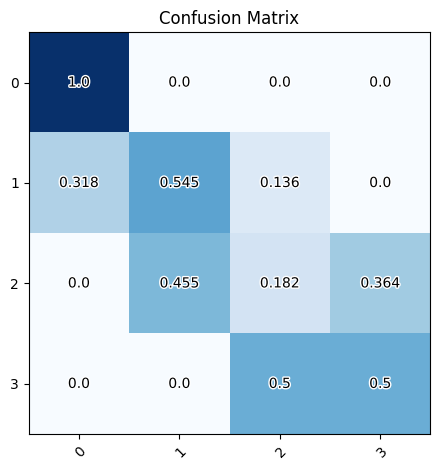

In [179]:
get_conf_matrix_results(model, val_dataloader)

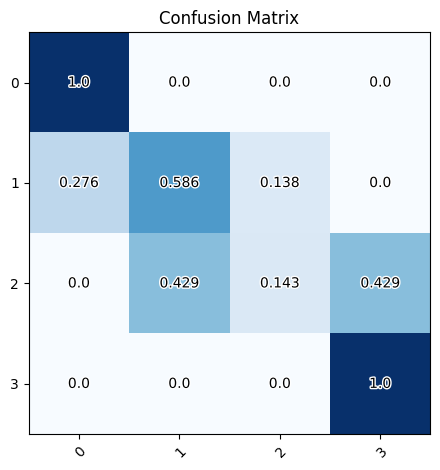

In [180]:
get_conf_matrix_results(model, test_dataloader)

In [168]:
trainer.validate(model, val_dataloader, ckpt_path='best')

Restoring states from the checkpoint path at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new fazekas prediction code/epoch=41-step=714-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new fazekas prediction code/epoch=41-step=714-v2.ckpt


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.8028272390365601
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.8028272390365601}]

In [169]:
print(run_eval_2(model, val_dataloader))
print(run_eval_2(model, test_dataloader))

torch.Size([41]) torch.Size([41])
tensor(0.4878)
torch.Size([42]) torch.Size([42])
tensor(0.5238)


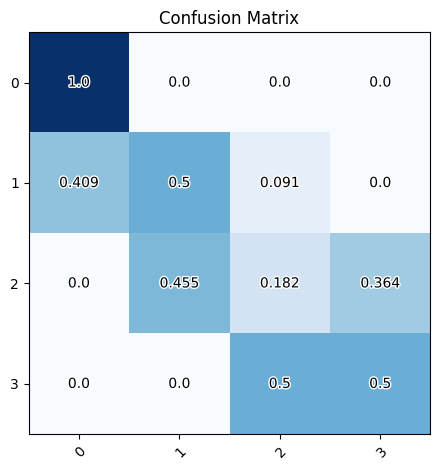

In [170]:
get_conf_matrix_results(model, val_dataloader)

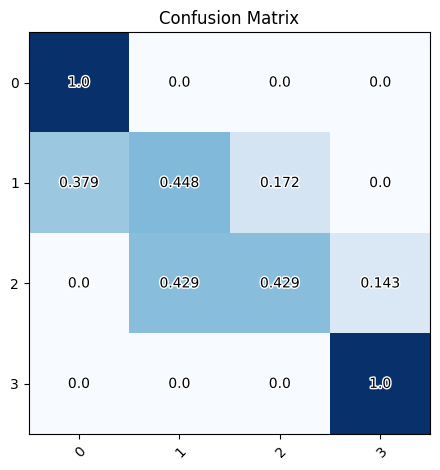

In [171]:
get_conf_matrix_results(model, test_dataloader)

In [160]:
trainer.validate(model, val_dataloader, ckpt_path='best')

Restoring states from the checkpoint path at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new fazekas prediction code/epoch=38-step=663.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new fazekas prediction code/epoch=38-step=663.ckpt


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.7514373660087585
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.7514373660087585}]

In [161]:
print(run_eval_2(model, val_dataloader))
print(run_eval_2(model, test_dataloader))

torch.Size([41]) torch.Size([41])
tensor(0.5610)
torch.Size([42]) torch.Size([42])
tensor(0.5476)


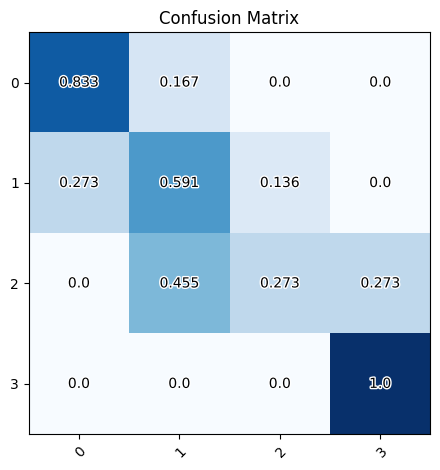

In [162]:
get_conf_matrix_results(model, val_dataloader)

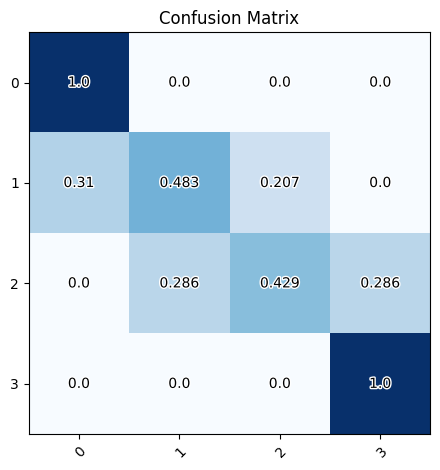

In [163]:
get_conf_matrix_results(model, test_dataloader)

In [152]:
trainer.validate(model, val_dataloader, ckpt_path='best')

Restoring states from the checkpoint path at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new fazekas prediction code/epoch=45-step=782-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new fazekas prediction code/epoch=45-step=782-v2.ckpt


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.7386007905006409
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.7386007905006409}]

In [153]:
print(run_eval_2(model, val_dataloader))
print(run_eval_2(model, test_dataloader))

torch.Size([41]) torch.Size([41])
tensor(0.5610)
torch.Size([42]) torch.Size([42])
tensor(0.5000)


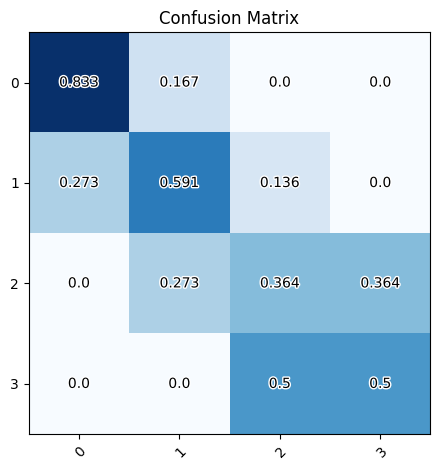

In [154]:
get_conf_matrix_results(model, val_dataloader)

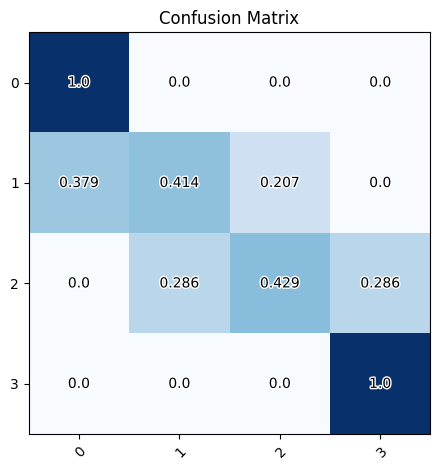

In [155]:
get_conf_matrix_results(model, test_dataloader)

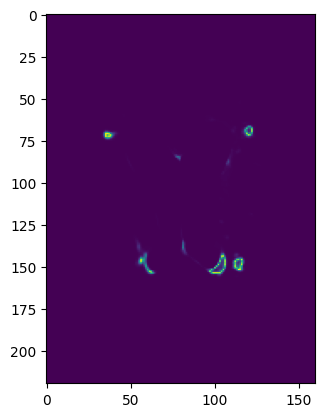

In [139]:
batch = next(iter(test_dataloader))
plt.imshow(batch[0][0][5][10])